### 1. Load project

In [111]:
using DrWatson
@quickactivate "JuMP-DrWatson Example"

### 2. Load data for customers and facilities

In [112]:
using CSV, DataFrames

In [113]:
C = CSV.read(datadir("customers.csv"), DataFrame)

,ID,x_coord,y_coord,demand
,Int64,Float64,Float64,Int64
1,1,0.505181,0.830769,25
2,2,0.448435,0.521569,21
3,3,0.132909,0.315383,18
4,4,0.245557,0.4133,20
5,5,0.744088,0.255979,27
6,6,0.531909,0.605737,19
7,7,0.229053,0.872867,13
8,8,0.962639,0.224656,19
9,9,0.488926,0.125628,21


In [114]:
F = CSV.read(datadir("facilities.csv"), DataFrame)

,ID,x_coord,y_coord,capacity,fixed_cost
,Int64,Float64,Float64,Int64,Float64
1,1,0.275855,0.436745,118,0.4
2,2,0.950362,0.22688,104,0.67
3,3,0.718727,0.191534,136,0.26
4,4,0.788685,0.81876,112,0.82
5,5,0.0490049,0.206744,138,0.93
6,6,0.254498,0.640604,140,0.74
7,7,0.212028,0.757836,131,0.62
8,8,0.306419,0.783723,129,0.09
9,9,0.28817,0.620169,122,0.62


### 3. Visualize locations of customers and potential facilities

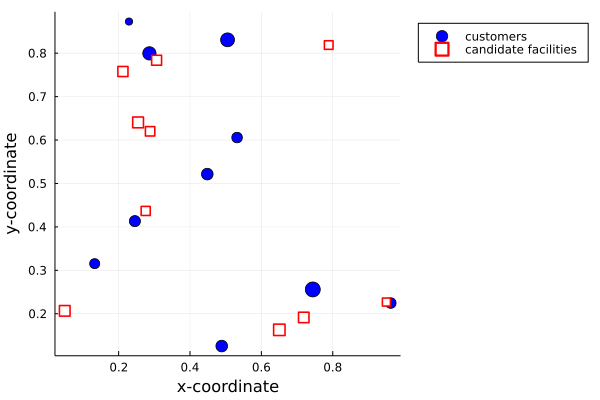

In [115]:
include(srcdir("plot.jl"))
fig1 = show_network(C, F)

### 4. Build MILP Model

In [116]:
using JuMP, HiGHS
include(srcdir("utils.jl"))

add_facilities (generic function with 1 method)

In [117]:
#calculate euclidean distance
function dist(f, c, F, C)
    Δx = F[f,:x_coord] - C[c,:x_coord]
    Δy = F[f,:y_coord] - C[c,:y_coord]
    δ = √(Δx^2 + Δy^2)
end

#create model and define solver to use (HiGHS)
function facility_location(F, C)
    m = Model(HiGHS.Optimizer)
    #get distance matrix
    @expression(m, distance[f ∈ F.ID, c ∈ C.ID], dist(f,c,F,C))
    #create variables
    @variable(m, y[f ∈ F.ID], Bin)
    @variable(m, 0 ≤ x[f ∈ F.ID, c ∈ C.ID] ≤ C.demand[c])
    #create constraints
    @constraint(m, demand[c ∈ C.ID], ∑(x[f,c] for f ∈ F.ID) ≤ C.demand[c])
    @constraint(m, capacity[f ∈ F.ID], ∑(x[f,c] for c ∈ C.ID) ≤ F.capacity[f] * y[f])
    #define objective function
    @objective(m, Min, 
        ∑(F.fixed_cost[f] * y[f] for f ∈ F.ID) 
        + 
        ∑(distance[f,c] * x[f,c] for f ∈ F.ID, c ∈ C.ID)
        +
        ∑(C.demand[c] - ∑(x[f,c] for f in F.ID) for c in C.ID)
    )

    return m
end

m = facility_location(F,C)
optimize!(m)

Presolving model
20 rows, 110 cols, 210 nonzeros
20 rows, 110 cols, 210 nonzeros

Solving MIP model with:
   20 rows
   110 cols (10 binary, 0 integer, 0 implied int., 100 continuous)
   210 nonzeros

( 0.0s) Starting symmetry detection
( 0.0s) No symmetry present

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   -910.5473242    inf                  inf        0      0      0         0     0.0s
 S       0       0         0   0.00%   -910.5473242    28.27916544     3319.85%        0      0      0         0     0.0s
         0       0         0   0.00%   25.36963321     28.27916544       10.29%        0      0      0        18     0.0s
 L       0       0         0   0.00%   27.7702278      28.25363798        1.71%       39      5      0        23     0.0s



### 5. Visualize Solution

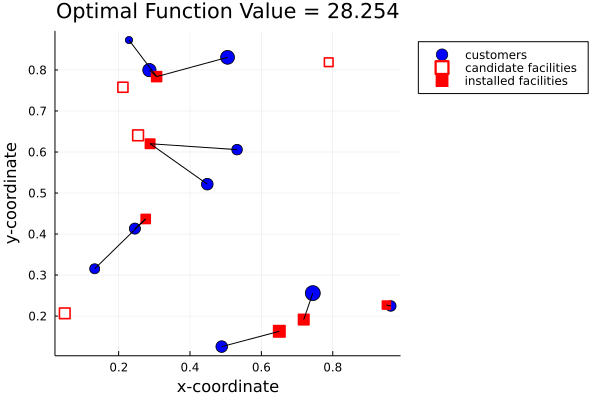

In [118]:
fig2 = show_network(C, F, m)

### 6. Sensitivity Study
Increase the number of customers and candidate facilities from 10 to 20.

In [119]:
#define parameters to change
num_facilities = collect(11:15)
num_customers = collect(11:15)
all_params = @strdict num_facilities num_customers
params = dict_list(all_params)

#define facilities and customers
Fnew = add_facilities(F, maximum(num_facilities))
Cnew = add_customers(C, maximum(num_customers))

#define function to call MILP model
function run_model(d)
    #get parameters for sensitivity study
    @unpack num_facilities, num_customers = d
    #build and run model
    m = facility_location(Fnew[1:num_facilities,:],Cnew[1:num_customers,:])
    optimize!(m)
    #save objective function value and number of facilities used
    result = Dict(
        "facilities_available" => num_facilities,
        "customers" => num_customers,
        "objective_value" => objective_value(m),
        "facilities_installed" => sum(value.(m[:y])),
        "installed_capacity" => sum(value.(m[:x])),
        "solution_time" => solve_time(m),
        "relative_gap" => relative_gap(m),
        "node_count" => node_count(m)
    )

    return result
end

run_model (generic function with 2 methods)

In [120]:
#run sensitivity study and save outputs
for (i,d) in enumerate(params)
    res = run_model(d)
    wsave(datadir("sensitivity", savename(d, "jld2")), res)
end

Presolving model
22 rows, 132 cols, 253 nonzeros
22 rows, 132 cols, 253 nonzeros

Solving MIP model with:
   22 rows
   132 cols (11 binary, 0 integer, 0 implied int., 121 continuous)
   253 nonzeros

( 0.0s) Starting symmetry detection
( 0.0s) No symmetry present

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   -1177.812205    inf                  inf        0      0      0         0     0.0s
 S       0       0         0   0.00%   -1177.812205    26.82431671     4490.84%        0      0      0         0     0.0s
         0       0         0   0.00%   23.93680956     26.82431671       10.76%        0      0      0        19     0.0s
 T       0       0         0   0.00%   25.78821497     26.79878924        3.77%       53      7      0        26     0.0s



┌ Info: Scanning folder c:\Users\hperezpa\Downloads\JuMP-DrWatson Example\data\sensitivity for result files.
└ @ DrWatson C:\Users\hperezpa\.julia\packages\DrWatson\S4dYA\src\result_collection.jl:115
┌ Info: Added 25 entries.
└ @ DrWatson C:\Users\hperezpa\.julia\packages\DrWatson\S4dYA\src\result_collection.jl:191


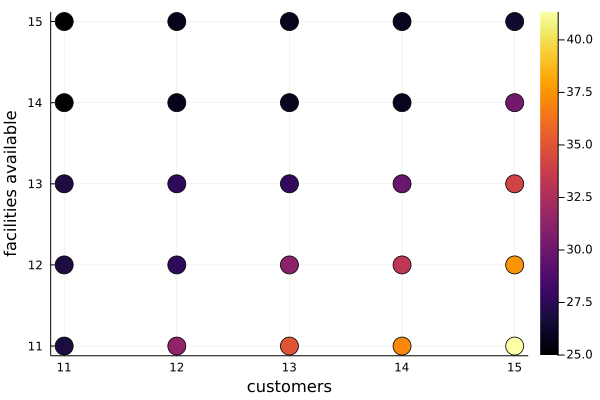

In [121]:
#analyze results
results = collect_results(datadir("sensitivity"))
fig3 = scatter(
    results.customers, 
    results.facilities_available,
    marker_z = results.objective_value,
    xlabel = "customers",
    ylabel = "facilities available",
    zlabel = "objective value",
    markersize = 10,
    colorbar = true,
    legend = :none
)

### 7. Save figures

In [122]:
savefig(fig1,plotsdir("network.png"))
savefig(fig2,plotsdir("network_optimal.png"))
savefig(fig3,plotsdir("sensitivity.png"))